In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import regularizers
from keras import backend as K
from keras import Sequential, Input
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt

import math

In [2]:
# make the result reproducible
keras.utils.set_random_seed(42)

In [3]:
physical_devices = tf.config.list_physical_devices()
print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

## Building Dataset

### Attributes description

- a1 - face containing flag: (1-with face, 0-without face),
- a2 - image number in current class (person) beginning from 0,
- a3 - class (person) number beginning from 0,
- a4 - sex (0 - woman, 1 - man)
- a5 - race (0- white, 1 - negro, 2 - indian, ...)
- a6 - age (0 - baby, 1 - young, 2 - middle-age, 3 - old) 
- a7 - binokulars (0 - without, 1 - transparent, 2 - dark)
- a8 - emotional expression (not state!) (0 - sad, 1 - neutral, 2 - happy)

In [5]:
from utils.load_dataset import load_dataset

DIRPATH = './data'
X_train, X_test, y_train, y_test = load_dataset(DIRPATH)

## Building a model

Testing LeNet-5 Architecture

In [6]:
from utils.constrains import CLASSES, IMAGE_SIZE

conv_regularizer = regularizers.l2(0.0006)
dense_regularizer = regularizers.l2(0.01)

# conv_regularizer = regularizers.l2(0)
# dense_regularizer = regularizers.l2(0)

activation_def = 'tanh'

model = Sequential(
  [
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    layers.Conv2D(6, kernel_size=5, padding='same', activation=activation_def, kernel_regularizer=conv_regularizer),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Dropout(0.15),
    layers.Conv2D(16, kernel_size=5, padding='same', activation=activation_def, kernel_regularizer=conv_regularizer),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Dropout(0.25),
    layers.Conv2D(120, kernel_size=5, padding='same', activation=activation_def, kernel_regularizer=conv_regularizer),

    layers.Flatten(),
    layers.Dropout(0.35),
    layers.Dense(84, activation=activation_def, kernel_regularizer=dense_regularizer),
    layers.Dense(CLASSES, activation='softmax'),
  ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 16)          0

In [7]:
# def get_lr_metric(optimizer):
#   def lr(y_true, y_pred):
#     return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
#   return lr

# lr_metric = get_lr_metric(optimizer)
# model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=["accuracy", lr_metric])


optimizer = Adam(learning_rate=0.001)
model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=["accuracy"])

In [8]:
# def step_decay(epoch):
#   initial_lrate = 0.1
#   drop = 0.9
#   epochs_drop = 10.0
#   lrate = initial_lrate * math.pow(drop,  
#           math.floor((1+epoch)/epochs_drop))
#   return lrate
 
# lrate_scheduler_callback = LearningRateScheduler(step_decay)

## Training Preparation

In [9]:
CHECKPOINT_PATH = 'models/checkpoints/famous48_test_model_v2_best.keras'

In [10]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=CHECKPOINT_PATH,
  save_weights_only=False,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True,
)

In [11]:
%%time
batch_size = 200
epochs = 20

history = model.fit(
  X_train, y_train,
  batch_size=batch_size,
  epochs=epochs,
  validation_split=0.2,
  shuffle=True,
  # callbacks=[model_checkpoint_callback, lrate_scheduler_callback]
)

Epoch 1/20
22/22 [==============================] - 3s 24ms/step - loss: 4.9319 - accuracy: 0.0663 - val_loss: 4.2841 - val_accuracy: 0.1197
Epoch 2/20
22/22 [==============================] - 1s 29ms/step - loss: 3.6980 - accuracy: 0.2220 - val_loss: 3.2366 - val_accuracy: 0.2797
Epoch 3/20
22/22 [==============================] - 0s 15ms/step - loss: 2.9385 - accuracy: 0.3487 - val_loss: 2.7531 - val_accuracy: 0.3647
Epoch 4/20
22/22 [==============================] - 0s 10ms/step - loss: 2.5687 - accuracy: 0.4326 - val_loss: 2.4915 - val_accuracy: 0.4260
Epoch 5/20
22/22 [==============================] - 0s 10ms/step - loss: 2.3682 - accuracy: 0.4785 - val_loss: 2.2455 - val_accuracy: 0.4991
Epoch 6/20
22/22 [==============================] - 0s 12ms/step - loss: 2.2024 - accuracy: 0.5208 - val_loss: 2.1267 - val_accuracy: 0.5439
Epoch 7/20
22/22 [==============================] - 0s 10ms/step - loss: 2.0991 - accuracy: 0.5457 - val_loss: 2.0244 - val_accuracy: 0.5612
Epoch 8/20
22

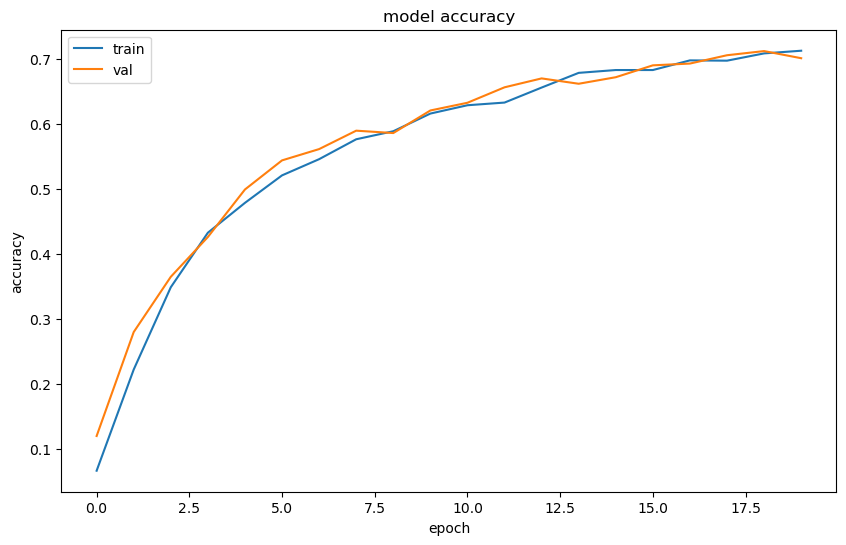

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
length = len(history.history['accuracy'])
print("train set accuracy:", round(history.history['accuracy'][length-1], 2))
print("validation set accuracy:", round(history.history['val_accuracy'][length-1], 2))

train set accuracy: 0.71
validation set accuracy: 0.7


In [14]:
# model.load_weights("models/checkpoints/famous48_test_model_v2_best.keras")
results = model.evaluate(X_test, y_test)
print("test set accuracy:", round(results[1], 2))

43/43 [==============================] - 0s 4ms/step - loss: 1.4708 - accuracy: 0.7030
test set accuracy: 0.7
